<span style="color: purple">

Load in stored variables:

</span>

In [1]:
%store -r data_dir sites_gdf siskiyou_forest_gdf padres_forest_gdf

<span style="color: purple">

Import packages:

</span>

In [2]:
# Import necessary packages
import os # make data directories
from math import floor, ceil # round numbers to nearest integers

import pandas as pd # data analysis and manipulation
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters

## STEP 2a: DATA ACCESS - SOIL

The [POLARIS dataset](http://hydrology.cee.duke.edu/POLARIS/) is a
convenient way to uniformly access a variety of soil parameters such as
pH and percent clay in the US. It is available for a range of depths (in
cm) and split into 1x1 degree tiles.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a <strong>function with a numpy-style docstring</strong> that
will download POLARIS data for a particular location, soil parameter,
and soil depth. Your function should account for the situation where
your site boundary crosses over multiple tiles, and merge the necessary
data together.</p>
<p>Then, use loops to download and organize the rasters you will need to
complete this section. Include soil parameters that will help you to
answer your scientific question. We recommend using a soil depth that
best corresponds with the rooting depth of your species.</p></div></div>

<span style="color: purple">

I will focus on soil pH. According to the [USDA PLANTS Database](https://plants.usda.gov/plant-profile/SESE3/characteristics), *S. sempervirens* prefer a soil pH of 5.0-7.0. Also, their minimum root depth is 40 inches (~102 cm), so I will focus on soil depths of 100-200 cm.

</span>

In [3]:
#  Define the URL template to download soil data from POLARIS
def soil_url_temp(variable='variable',
                  statistic='statistic',
                  depth='depth'):
    """
    Create a URL template for downloading soil data from POLARIS.

    Parameters
    ----------
    variable : str
        The soil `variable` of interest.
    statistic : {'mean', 'mode', 'p5', 'p50', 'p95'}
        The `statistic` type of interest.
    depth : {'0_5', '5_15', '15_30', '30_60', '60_100', or '100_200'}
        The `depth` of interest in cm.

    Returns
    -------
    soil_url_template : str
        Template of the URL to download the soil data.
    """
    soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
                    "v1.0"
                    f"/{variable}"
                    f"/{statistic}"
                    f"/{depth}"
                    "/lat{min_lat}{max_lat}"
                    "_lon{min_lon}{max_lon}.tif")
    return soil_url_template

In [4]:
# Define site bounds
def define_site_bounds(site_gdf):
    """
    Identify the bounds of a geographic site.
     
    Specifically, this function creates a tuple with
    a DataArray of the site bounds and the minimum longitude,
    minimum latitude, maximum longitude, and maximum latitude of a site.

    Parameters
    ----------
    site_gdf : GeoDataFrame
        The GeoDataFrame of the site of interest.

    Returns
    -------
    site_bounds : DataArray
        A DataArray with the minimum and maximum longitude and
        minimum and maximum latitude of the site.
    site_bounds_min_lon : float
        The minimum longitude of the site.
    site_bounds_min_lat : float
        The minimum latitude of the site.
    site_bounds_max_lon : float
        The maximum longitude of the site.
    site_bounds_max_lat : float
        The maximum latitude of the site.
    """
    site_bounds = (site_bounds_min_lon,
                   site_bounds_min_lat,
                   site_bounds_max_lon,
                   site_bounds_max_lat) = (
                       site_gdf
                       .total_bounds)
    return (site_bounds, site_bounds_min_lon, site_bounds_min_lat,
    site_bounds_max_lon, site_bounds_max_lat)

In [5]:
# Process soil DataArrays
def process_soil_da(site_soil_dir,
                    soil_url_template,
                    site_bounds,
                    site_bounds_min_lon,
                    site_bounds_min_lat,
                    site_bounds_max_lon,
                    site_bounds_max_lat,
                    variable='variable',
                    statistic='statistic',
                    depth='depth'):
    """
    Save, open, scale, and crop raster soil data.

    Parameters
    ----------
    site_soil_dir : str
        The directory where the soil data will be saved.
    soil_url_template : str
        Template of the URL to download the soil data.
    site_bounds : DataArray
        A DataArray with the minimum and maximum longitude and
        minimum and maximum latitude of the site.
    site_bounds_min_lon : float
        The minimum longitude of the site.
    site_bounds_min_lat : float
        The minimum latitude of the site.
    site_bounds_max_lon : float
        The maximum longitude of the site.
    site_bounds_max_lat : float
        The maximum latitude of the site.
    variable : str
        The soil `variable` of interest.
    statistic : {'mean', 'mode', 'p5', 'p50', 'p95'}
        The `statistic` type of interest.
    depth : {'0_5', '5_15', '15_30', '30_60', '60_100', or '100_200'}
        The `depth` of interest in cm.

    Returns
    -------
    site_soil_das : list
        A list of DataArrays of soil data for the
        different rasters covering the site of interest.
    """
    site_soil_das = []
    # List out the soil files for download
    for min_lon in range(floor(site_bounds_min_lon),
                         ceil(site_bounds_max_lon)):
        for min_lat in range(floor(site_bounds_min_lat),
                             ceil(site_bounds_max_lat)):
            max_lon = min_lon + 1
            max_lat = min_lat + 1
            soil_url = soil_url_template.format(
                min_lat=min_lat,
                max_lat=max_lat,
                min_lon=min_lon,
                max_lon=max_lon)
            
            # Define file path for saving downloaded raster data
            soil_path = os.path.join(site_soil_dir,
                                     f"soil_{variable}_{statistic}_{depth}"
                                     f"_lat{min_lat}{max_lat}"
                                     f"_lon{min_lon}{max_lon}.tif")

            if not os.path.exists(soil_path):
                # Save raster data to soil path, mask and scale, squeeze
                soil_da = rxr.open_rasterio(
                    soil_url,
                    mask_and_scale=True
                    ).squeeze()
                soil_da.to_netcdf(soil_path)
                print(f'soil_da saved: {soil_path}')
            else:
                print(f'file already exists: {soil_path}')

            # Open and squeeze raster soil data
            soil_da = rxr.open_rasterio(
                soil_url,
                mask_and_scale=True
            ).squeeze()

            # Crop the raster soil data
            cropped_da = soil_da.rio.clip_box(*site_bounds)
            site_soil_das.append(cropped_da)
            print('Cropped')

    return site_soil_das

In [6]:
# Define data directory for the soil data
soil_ph_dir = os.path.join(data_dir, 'soil-ph')

os.makedirs(soil_ph_dir, exist_ok=True)

soil_ph_pattern = os.path.join (soil_ph_dir, '*.tif')
soil_ph_pattern

'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\soil-ph\\*.tif'

<span style="color: purple">

#### Load in Siskiyou National Forest soil pH data

</span>

In [7]:
# Define Siskiyou bounds
siskiyou_bounds = define_site_bounds(siskiyou_forest_gdf)

# Check bounds
siskiyou_bounds

(array([-124.41629676,   41.88061609, -123.30873415,   42.8864844 ]),
 np.float64(-124.41629675963702),
 np.float64(41.8806160868663),
 np.float64(-123.30873414962662),
 np.float64(42.886484404653714))

In [8]:
# Create soil pH url template (can be used to load in Los Padres soil data too)
soil_url_template = soil_url_temp(variable='ph', statistic='mean', depth='100_200')

# Check url template
soil_url_template

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/100_200/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif'

In [9]:
# Process Siskiyou soil pH DataArrays
siskiyou_soil_ph_indiv_das = process_soil_da(soil_ph_dir,
                                             soil_url_template,
                                             siskiyou_bounds[0],
                                             siskiyou_bounds[1],
                                             siskiyou_bounds[2],
                                             siskiyou_bounds[3],
                                             siskiyou_bounds[4],
                                             variable='ph',
                                             statistic='mean',
                                             depth='100_200')

file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat4142_lon-125-124.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat4243_lon-125-124.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat4142_lon-124-123.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat4243_lon-124-123.tif
Cropped


In [10]:
# Merge Siskiyou soil ph data tiles
siskiyou_soil_ph_da = merge_arrays(siskiyou_soil_ph_indiv_das)

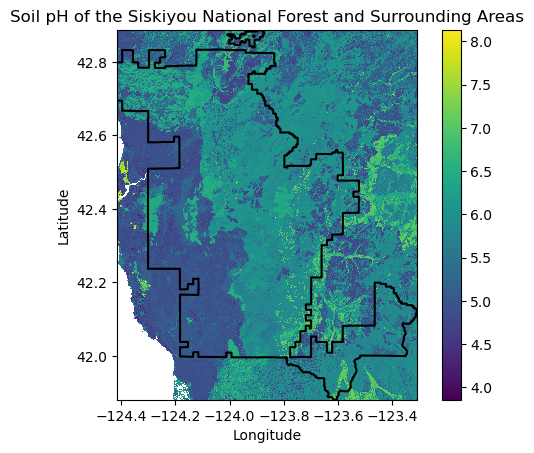

In [11]:
# Plot Siskiyou National Forest on siskiyou_soil_ph_da
siskiyou_soil_ph_da.plot()
siskiyou_forest_gdf.to_crs(siskiyou_soil_ph_da.rio.crs).boundary.plot(ax = plt.gca(), color='black')

# Add titles and axes to plot
plt.title('Soil pH of the Siskiyou National Forest and Surrounding Areas')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

<span style="color: purple">

#### Load in Los Padres National Forest soil pH data

</span>

In [12]:
# Define Los Padres bounds
padres_bounds = define_site_bounds(padres_forest_gdf)

# Check bounds
padres_bounds

(array([-121.84915641,   34.3915375 , -118.74267059,   36.40406272]),
 np.float64(-121.8491564113724),
 np.float64(34.391537504483146),
 np.float64(-118.74267058945019),
 np.float64(36.40406272249097))

In [13]:
# Process Los Padres soil pH DataArrays
padres_soil_ph_indiv_das = process_soil_da(soil_ph_dir,
                                             soil_url_template,
                                             padres_bounds[0],
                                             padres_bounds[1],
                                             padres_bounds[2],
                                             padres_bounds[3],
                                             padres_bounds[4],
                                             variable='ph',
                                             statistic='mean',
                                             depth='100_200')

file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat3435_lon-122-121.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat3536_lon-122-121.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat3637_lon-122-121.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat3435_lon-121-120.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat3536_lon-121-120.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat3637_lon-121-120.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soi

In [ ]:
# Merge Los Padres soil ph data tiles
# this takes about a minute
padres_soil_ph_da = merge_arrays(padres_soil_ph_indiv_das)

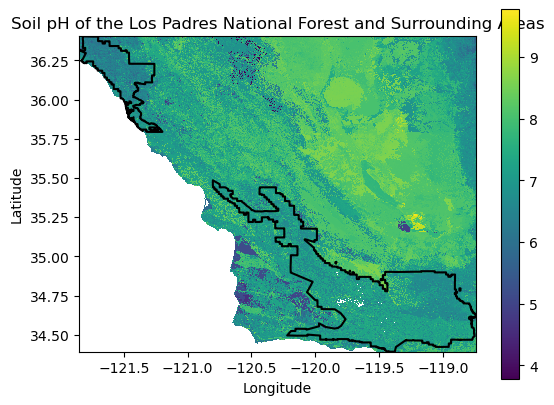

In [ ]:
# Plot padres National Forest on padres_soil_ph_da
# this took about 3 minutes
padres_soil_ph_da.plot()
padres_forest_gdf.to_crs(padres_soil_ph_da.rio.crs).boundary.plot(ax = plt.gca(), color='black')

# Add titles and axes to plot
plt.title('Soil pH of the Los Padres National Forest and Surrounding Areas')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

<span style="color: purple">

Use store magic to store soil pH DataArrays for both sites:

</span>

In [16]:
%store siskiyou_soil_ph_da padres_soil_ph_da

Stored 'siskiyou_soil_ph_da' (DataArray)
Stored 'padres_soil_ph_da' (DataArray)
